# JE VEUX MES GLACES


## Introduction

Sleep:

- A single sleep period must be at least 30 minutes in length
- A single sleep period can be interrupted by bouts of activity that do not exceed 30 consecutive minutes
- No sleep windows can be detected unless the watch is deemed to be worn for the duration (elaborated upon, below)
- The longest sleep window during the night is the only one which is recorded
- If no valid sleep window is identifiable, neither an onset nor a wakeup event is recorded for that night.
- Sleep events do not need to straddle the day-line, and therefore there is no hard rule defining how many may occur within a given period. However, no more than one window should be assigned per night. For example, it is valid for an individual to have a sleep window from 01h00–06h00 and 19h00–23h30 in the same calendar day, though assigned to consecutive nights
- There are roughly as many nights recorded for a series as there are 24-hour periods in that series.

TODO:

- Try to plot the sleep of one series trough time.
- Try to find periods where the watch is not worn.

## Import

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import polars as pl

In [2]:
df_signals = pl.read_parquet('data/train_series.parquet')

In [3]:
df_events = pd.read_csv('data/train_events.csv')

**Convert timestamp to datetime**

In [4]:
df_signals = df_signals.with_columns(pl.col('timestamp').str.to_datetime('%Y-%m-%dT%H:%M:%S%z'))

In [53]:
df_events.timestamp = pd.to_datetime(df_events.timestamp)

## Exploratory Data Analysis

**Missing Events**

In [25]:
df_events.isna().sum()

series_id       0
night           0
event           0
step         4923
timestamp    4923
dtype: int64

**Missing Data**

In [42]:
df_signals['timestamp'].is_null().sum() + \
df_signals['series_id'].is_null().sum() + \
df_signals['anglez'].is_null().sum() + \
df_signals['enmo'].is_null().sum()

0

### Basic stats

**number of series**

In [5]:
len(df_signals['series_id'].unique())

277

**number of nights**

In [6]:
len(df_events['night'].unique())

84

**number of events**

In [7]:
len(df_events['event'])

14508

**number of event by night**

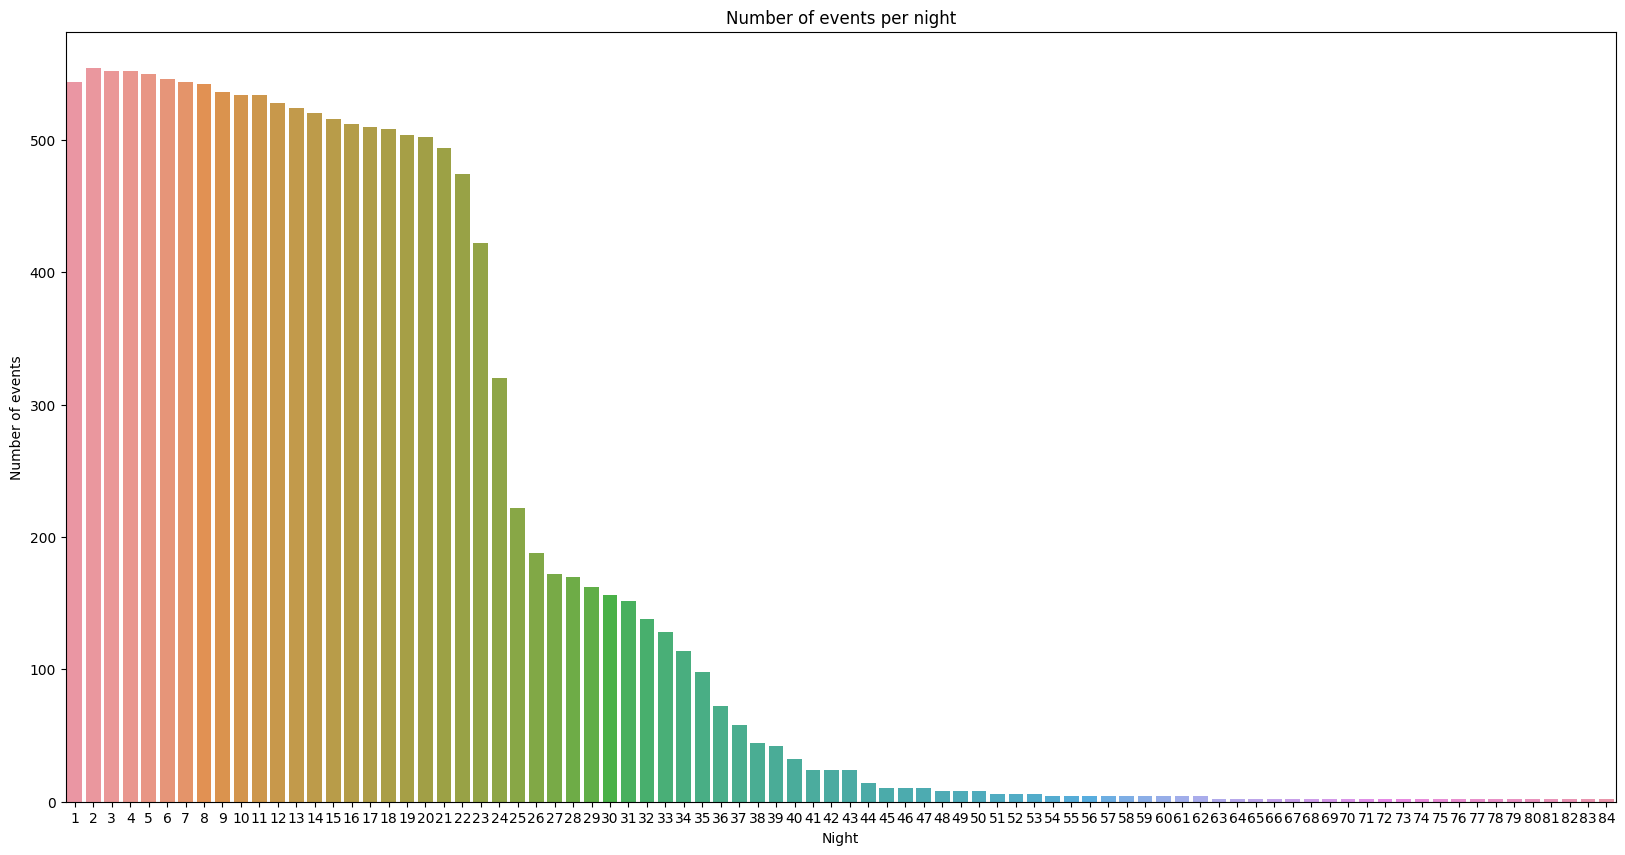

In [8]:
night_counts = df_events.groupby('night').size()
_, ax = plt.subplots(figsize=(20, 10))
sns.barplot(data = night_counts.reset_index(), x = 'night', y = 0, ax = ax)
ax.set_title('Number of events per night');
ax.set_xlabel('Night');
ax.set_ylabel('Number of events');

**number of event by series**

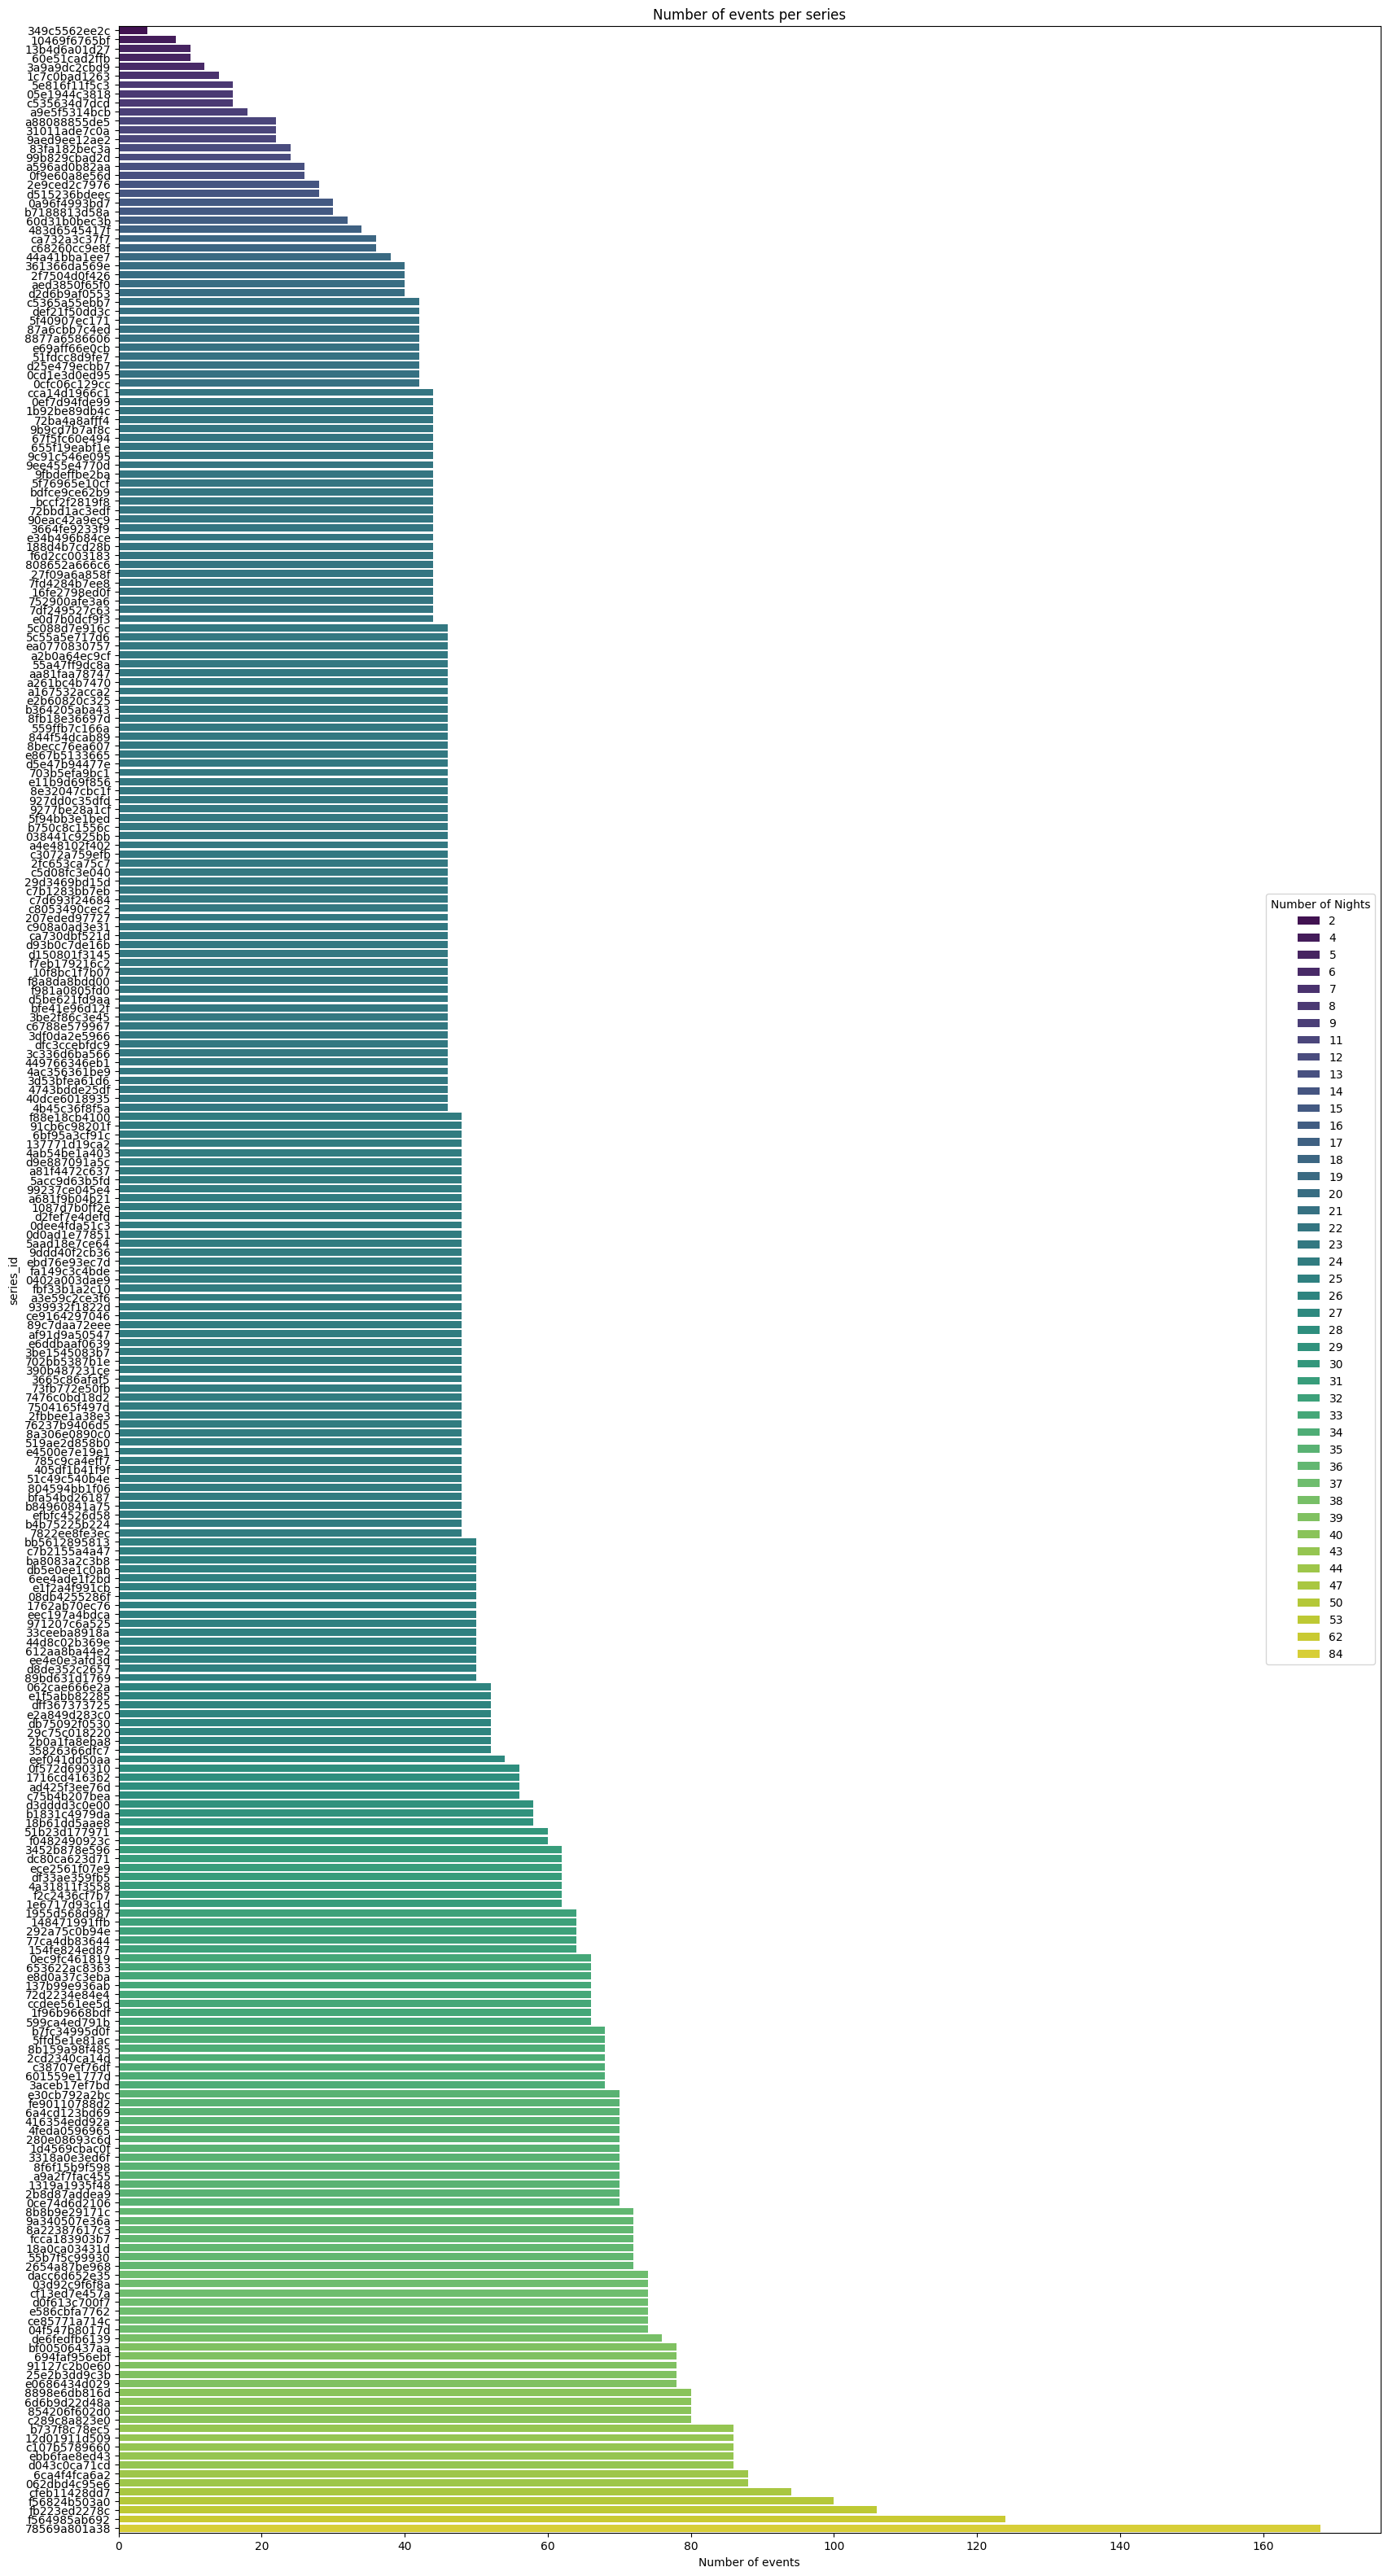

In [9]:
# Calculate number of nights by series and merge with event counts
df = df_events.groupby('series_id').agg(events=('series_id', 'size'), nights=('night', 'nunique')).reset_index()

# Plot
plt.figure(figsize=(20, 40))
sns.barplot(data=df.sort_values(by='events', ascending=True), y='series_id', x='events', hue='nights', dodge=False, palette="viridis")

# Setting titles and labels
plt.title('Number of events per series')
plt.ylabel('series_id')
plt.xlabel('Number of events')
plt.legend(title='Number of Nights', loc='best')

plt.show()


**AngleZ**

A metric derived from individual accelerometer components that is commonly used in sleep detection, and refers to the angle of the arm relative to the vertical axis of the body.

In the range [-90,90]


In [10]:
df_signals['anglez'].describe()

statistic,value
str,f64
"""count""",1.2794634e8
"""null_count""",0.0
"""mean""",-8.810476
"""std""",35.521875
"""min""",-90.0
"""25%""",-31.8589
"""50%""",-9.5979
"""75%""",11.3002
"""max""",90.0


**enmo**

ENMO is the Euclidean Norm Minus One of all accelerometer signals, with negative values rounded to zero. While no standard measure of acceleration exists in this space, this is one of the several commonly computed features.

Positive values

In [11]:
df_signals['enmo'].describe()

statistic,value
str,f64
"""count""",1.2794634e8
"""null_count""",0.0
"""mean""",0.041315
"""std""",0.101829
"""min""",0.0
"""25%""",0.0013
"""50%""",0.0172
"""75%""",0.0437
"""max""",11.4337


### Times Series Visualization

In [12]:
serie = df_signals.filter(df_signals["series_id"] == "038441c925bb")

**angle Z plot**

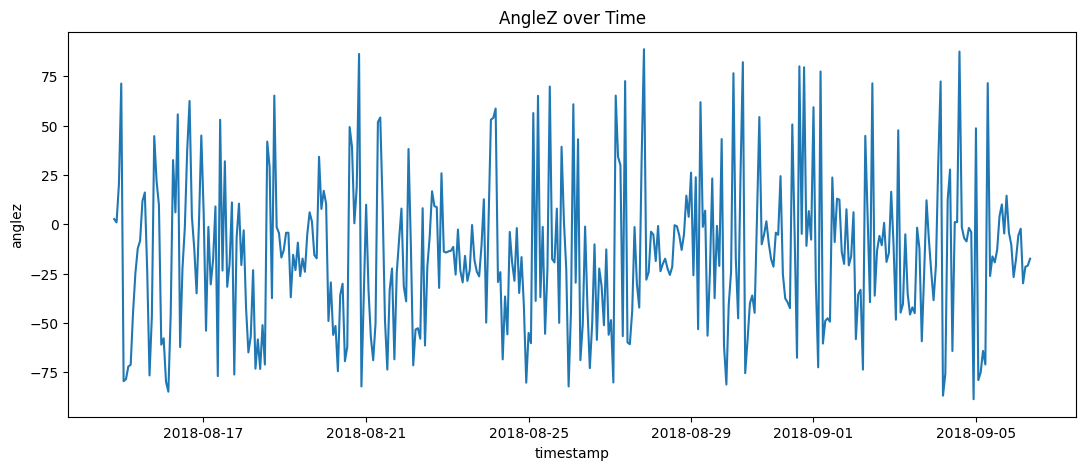

In [13]:
# Plotting anglez over time
_,ax = plt.subplots(figsize=(13,5))
sns.lineplot(data=serie[::1000], x='timestamp', y='anglez')
plt.title('AngleZ over Time')
plt.show()


**enmo plot**

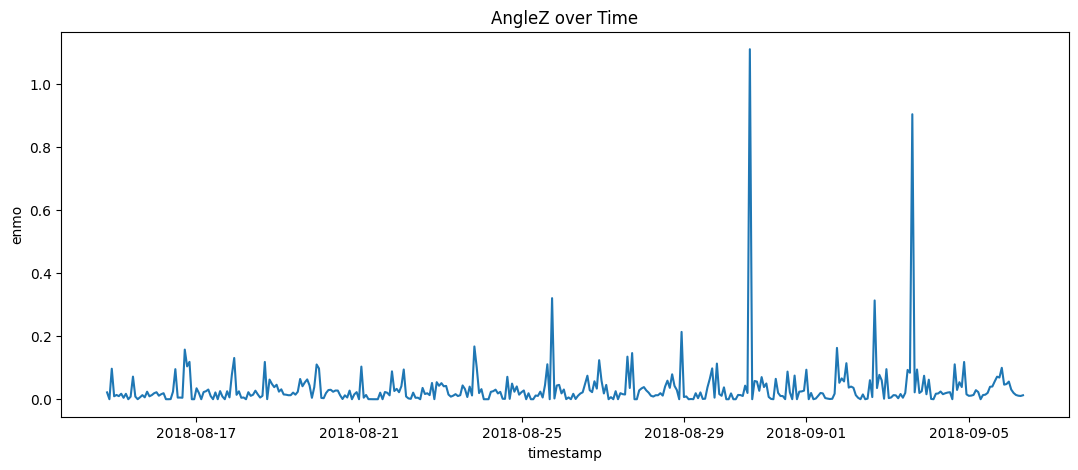

In [14]:
# Plotting enmo over time
_,ax = plt.subplots(figsize=(13,5))
sns.lineplot(data=serie[::1000], x='timestamp', y='enmo')
plt.title('AngleZ over Time')
plt.show()


**angle Z Distribution**

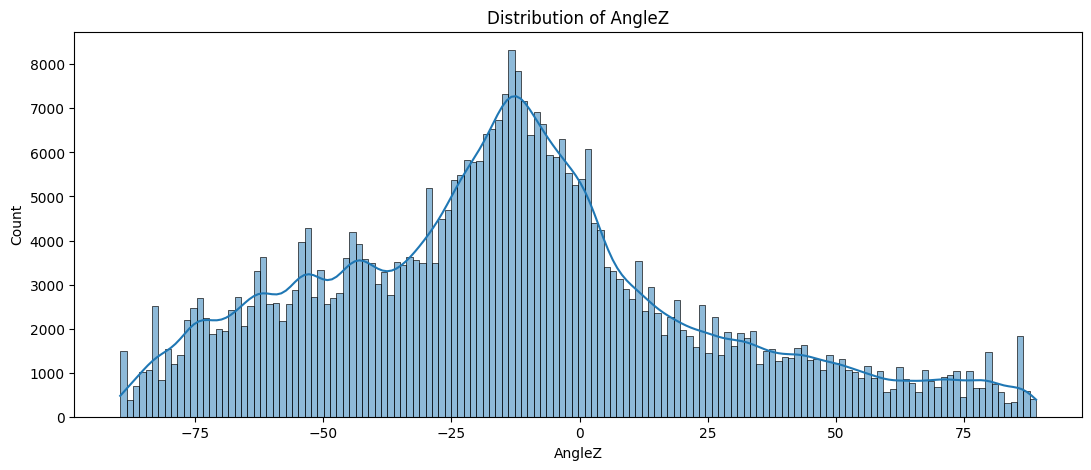

In [15]:
_,ax = plt.subplots(figsize=(13,5))

sns.histplot(serie['anglez'], kde=True)
plt.title('Distribution of AngleZ')
ax.set_xlabel('AngleZ')
plt.show()


**enmo Distribution**

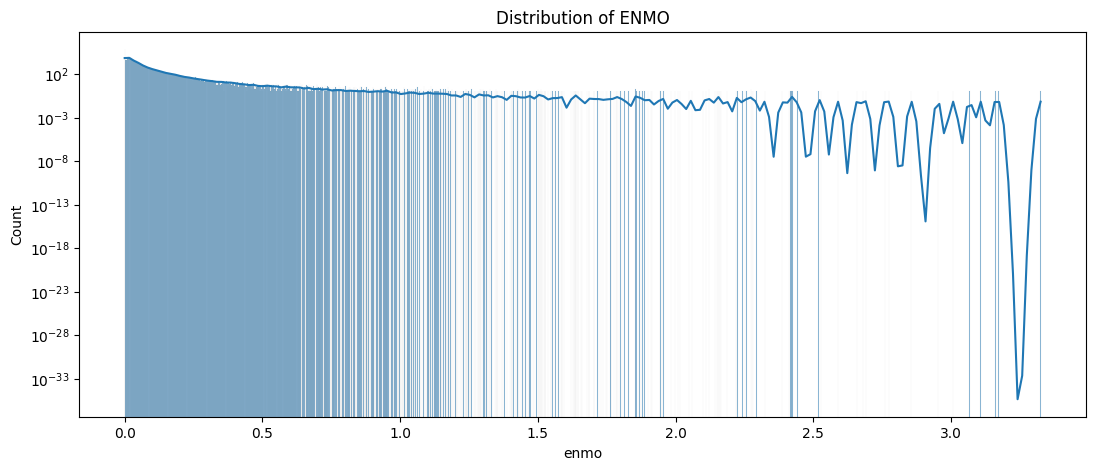

In [16]:
_,ax = plt.subplots(figsize=(13,5))
sns.histplot(serie['enmo'], kde=True)
plt.yscale('log')
plt.title('Distribution of ENMO')
ax.set_xlabel('enmo')
plt.show()

### Duration of each Series

In [17]:
duration = (
    df_signals.group_by('series_id').agg(
        duration = pl.col('timestamp').max() - pl.col('timestamp').min(),
        nb_rows = pl.col('timestamp').count()
    ).with_columns(pl.col('duration').cast(pl.Duration(time_unit='ms')))
)
duration

series_id,duration,nb_rows
str,duration[ms],u32
"""29c75c018220""",26d 20h 44m 55s,464220
"""db75092f0530""",25d 5h 14m 55s,435780
"""4b45c36f8f5a""",21d 23h 44m 55s,379980
"""31011ade7c0a""",32d 16h 29m 55s,564840
"""dacc6d652e35""",36d 20h 29m 55s,636840
"""292a75c0b94e""",32d 4h 29m 55s,556200
"""b84960841a75""",24d 8h 59m 55s,421200
"""390b487231ce""",22d 22h 14m 55s,396180
"""ce85771a714c""",36d 20h 59m 55s,637200


Text(0, 0.5, 'Percentage of Series')

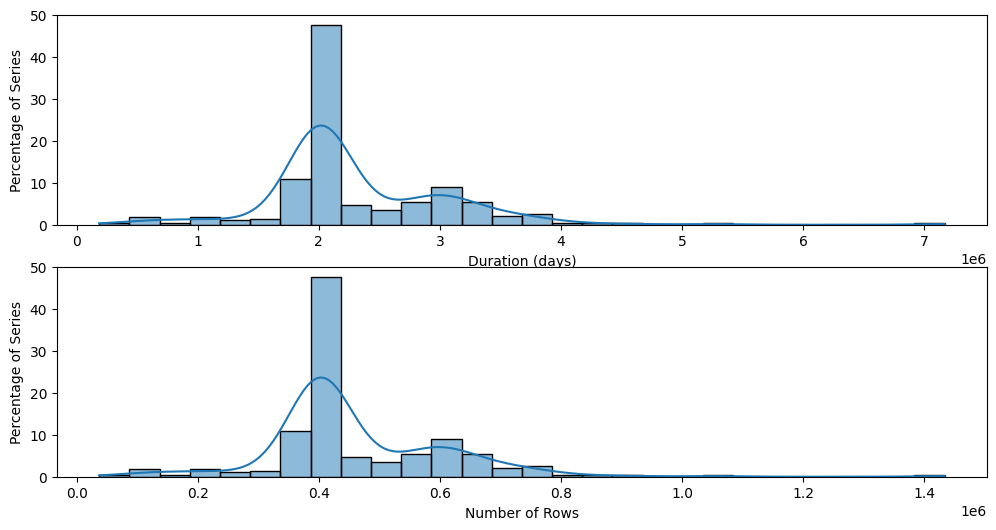

In [18]:
# Plot duration distribution
seconds = duration['duration'].dt.seconds()
nb_rows = duration['nb_rows']
_, (ax1,ax2) = plt.subplots(2,1, figsize=(12, 6))

sns.histplot(data=seconds, kde=True, ax=ax1, stat='percent')
ax1.set_xlabel('Duration (days)')
ax1.set_ylabel('Percentage of Series')

sns.histplot(data=nb_rows, kde=True, ax=ax2, stat='percent')
ax2.set_xlabel('Number of Rows')
ax2.set_ylabel('Percentage of Series')



### Plot of the sleep of one series trough time

In [56]:
serie_signals = df_signals.filter(df_signals["series_id"] == "1b92be89db4c")
serie_events = df_events.query(f"series_id == '1b92be89db4c'")

In [77]:
def plot_sleep(serie: str, df_events: pd.DataFrame, ax : plt.Axes) -> plt.Axes:
    """
    Plot sleep for a given serie_id

    Parameters
    ----------
    serie : str
        the serie_id to plot
    df_events : pd.DataFrame
        DataFrame containing the columns 'series_id', 'night', 'event', 'timestamp'
    """
    # Filter events for the given serie_id and sort by timestamp
    serie_events = df_events[df_events['series_id'] == serie].sort_values(by='timestamp', ascending=True)

    # Initialize containers for onsets and wakeups
    onset_times = []
    wakeup_times = []

    # Process events in order, pairing onsets with subsequent wakeups
    for idx, row in serie_events.iterrows():
        if row['event'] == 'onset':
            onset_times.append(row['timestamp'])
        elif row['event'] == 'wakeup' and onset_times:
            # Only plot if there is a previous 'onset' to pair with
            onset = onset_times.pop()
            wakeup = row['timestamp']
            
            ax.plot([onset, wakeup], [1, 1], color='blue', lw=10, solid_capstyle='butt')

    ax.set_yticks([])
    ax.set_xlabel('Time')
    ax.set_title(f"Sleep Periods for {serie}")
    
    return ax
    

<Axes: title={'center': 'AngleZ over Time'}, xlabel='Time', ylabel='anglez'>

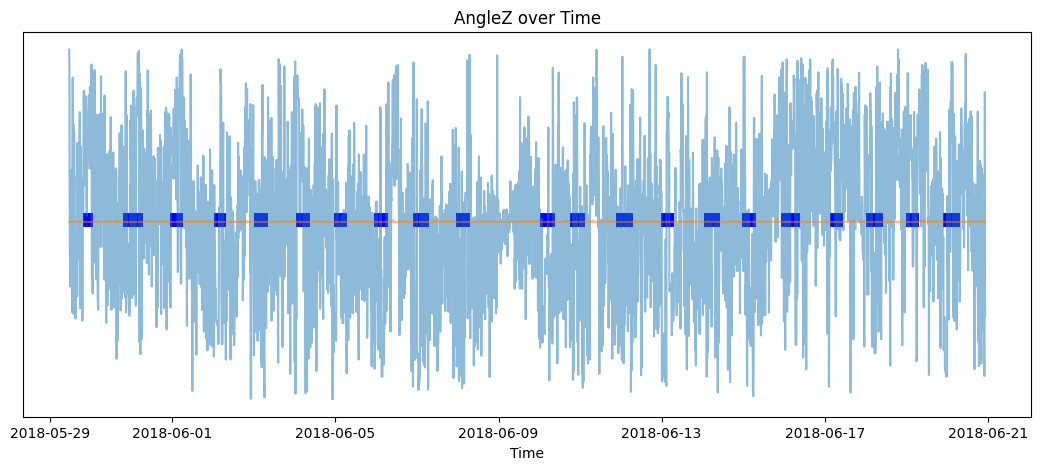

In [81]:
_, ax = plt.subplots(figsize=(13, 5))
plot_sleep('1b92be89db4c', df_events, ax)

sns.lineplot(data=serie_signals[::100], x='timestamp', y='anglez',alpha=0.5)
plt.title('AngleZ over Time')

sns.lineplot(data=serie_signals[::100], x='timestamp', y='enmo',alpha=0.5)

### Feature over all Series